In [1]:
import re
import os
import csv
import numpy as np
import pandas as pd
from itertools import chain
from scipy.stats import linregress

from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import Normalize
from seaborn import xkcd_palette

% matplotlib inline

import sys
if sys.platform=='darwin':
    top_path='/Users/codydirks/PGCC/'
else:
    top_path='/DataDisk/datafiles/PGCC_HST/'

x1d_dir=top_path+'x1d_files/'

c=300000.

class LineInfo(object):
    def __init__(self,dat_line,err_line):
        dat=dat_line.split()
        if len(dat)==10:
            self.ion=dat[0]
            self.n=float(dat[1])
            self.b=float(dat[2])
            self.wav=float(dat[3])
            self.v=float(dat[4])
            self.n_flag=int(dat[5])
            self.b_flag=int(dat[6])
            self.v_flag=int(dat[7])
            self.eqw=float(dat[8])
            self.tot_eqw=float(dat[9])
        elif len(dat)<10:
            self.ion=dat_line[0:10]
            self.n=float(dat_line[10:20])
            self.b=float(dat_line[20:28])
            self.wav=float(dat_line[28:38])
            self.v=float(dat_line[38:48])
            self.n_flag=int(dat_line[48:52])
            self.b_flag=int(dat_line[52:54])
            self.v_flag=int(dat_line[54:56])
            self.eqw=float(dat_line[56:64])
            self.tot_eqw=float(dat_line[64:])
        
        errs=err_line.split()
        self.n_err=float(errs[0])
        self.b_err=float(errs[1])
        self.v_err=float(errs[2])
        
    def __repr__(self):
        return self.ion
    def __str__(self):
        return self.ion

def load_results(filename):
    gaia_filenames=[top_path+'gaia_data/TgasSource_000-000-0'+'{:02}'.format(i)+'.fits' for i in range(16)]
    pgcc_data=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')[1].data
    sightline_pgcc_gaia_data=[]
    with open(filename,'r') as myfile:
        for line in myfile:
            dat=line.strip('|\n').split('|')
            sightline=dat[0]
            coords=dat[1].split(' ')
            ra=float(coords[0])*u.degree
            dec=float(coords[1])*u.degree
            pgcc=pgcc_data[int(dat[2])]
            if dat[3] != 'None':
                fl,idx=map(int,dat[3][1:-1].split(','))
                gaia_entry=fits.open(gaia_filenames[fl])[1].data[idx]
            else:
                gaia_entry=None
                
            sightline_pgcc_gaia_data.append([sightline,(ra,dec),pgcc,gaia_entry])
    return sightline_pgcc_gaia_data

# Returns the velocity shift necessary to convert Helio to LSR
# i.e. returns (V_lsr - V_helio)
def HelioToLSR(target_ra_deg, target_dec_deg):
    Vsun=19.7
    a0=271.0*np.pi/180.
    d0=30.0*np.pi/180.
    a=target_ra_deg*np.pi/180.
    d=target_dec_deg*np.pi/180.
    #shift=Vsun*(np.cos(a-a0)*np.cos(a0)*np.cos(a)+np.sin(d0)*np.sin(d))
    shift=Vsun*(np.cos(a0)*np.cos(d0)*np.cos(a)*np.cos(d)
                +np.sin(a0)*np.cos(d0)*np.sin(a)*np.cos(d)
                +np.sin(d0)*np.sin(d))
    return shift


def get_r_dist(pgcc,sightline_ra,sightline_dec):
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    gal=SkyCoord(ra=sightline_ra*u.degree,dec=sightline_dec*u.degree,frame='icrs').galactic
    del_l=60.*(gal.l.value-pgcc['glon'])
    del_b=60.*(gal.b.value-pgcc['glat'])
    return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))



def parse_results_file(filename):
    ids=['O_I]','Cl_I','C_I','C_I*','C_I**','CO','13CO','Ni_II','Kr_I','Ge_II','Mg_II']
    ions=[]
    with open(filename) as myfile:
        lines=[x.strip() for x in myfile.readlines()]
        for i in range(len(lines)):
            if len(lines[i].strip())>0:
                dat=lines[i].split()
                if any([dat[0]==x for x in ids]) or dat[0].startswith('CO_'):
                    ions.append(LineInfo(lines[i],lines[i+1]))
    return ions

def get_sightline_fits6p_results(sightline, ion):
    del_v_tol=1.5
    data=[]
    fits6p_prefix=get_fits6p_ion(ion)
    for fl in [x for x in os.listdir(x1d_dir+sightline+'/E140H') if x.startswith(fits6p_prefix) and x.endswith('.txt')]:
        ions=parse_results_file(x1d_dir+sightline+'/E140H/'+fl)
        if 'CO' in ion:
            selected_ions=[i for i in ions if i.ion.startswith(ion)]
        else:
            selected_ions=[i for i in ions if i.ion==ion]
        data.append((fl,selected_ions))
    return data


def get_f_star(el1row,el2row,el1n,el2n,el1err,el2err):
    fs=np.arange(-1,3,0.01)
    a1,a1err,b1,b1err,x1,x1err=chain.from_iterable([[el1row[idx],el1row['e_'+idx]] for idx in ('Ax','Bx','[X/H]')])
    z1=el1row['zx']
    a2,a2err,b2,b2err,x2,x2err=chain.from_iterable([[el2row[idx],el2row['e_'+idx]] for idx in ('Ax','Bx','[X/H]')])
    z2=el1row['zx']
    el1_depls=b1+a1*(fs-z1)
    el2_depls=b2+a2*(fs-z2)
    
    rats=el1_depls-el2_depls
    rat=el1n-el2n-(x1-12)+(x2-12)
    f=fs[np.abs(rats-rat).argmin()]
    
    f_err=np.sqrt((el1err**2+el2err**2
                    #+x1err**2+x2err**2
                    #+b1err**2+b2err**2
                    #+(z1*(a1-a2)*a1err)**2 + (z2*(a1-a2)*a2err)**2
                    #+((a1*z1)**2+(a2*z2)**2)*(a1err**2+a2err**2)
                  )/(a1-a2)**2
                 )
    return f,f_err


def get_fits6p_ion(strng):
    return strng.strip('*').replace('_','').lower().replace('i','I').replace('nI','ni').strip(']')

def get_table_ion(strng):
    return strng.replace('_I]','').replace('_II','').replace('_I','')

In [2]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()
    
filename='sightline_pgcc_gaia_results.txt'
all_data=load_results(filename)
all_data.sort(key=lambda x: (x[0][0],int(re.search(r'\d+',x[0]).group())))

primary_sample=[x for x in all_data if x[0] in primary_sightlines]
len(primary_sample)

22

In [3]:
del_v_tol=1.5
ion_list=['O_I]','Cl_I','C_I','C_I*','C_I**','CO','13CO','Ni_II','Kr_I','Ge_II','Mg_II']
ns_dict={}
info={'Sightline':[],'R_dist':[],'Velocity':[]}
for ion in ion_list:
    ns_dict[ion]=0
    
    info[get_table_ion(ion)]=[]
    info[get_table_ion(ion)+'_err']=[]
    
all_data=pd.DataFrame(info)
    
for sl in primary_sample:
    info['Sightline']=sl[0]
    ra,dec=sl[1]
    galcoords=SkyCoord(ra=ra,dec=dec).galactic
    pgcc=sl[2]
    info['R_dist']=round(get_r_dist(pgcc,ra.value,dec.value),2)
    
    data_dict={}
    for ion in ion_list:
        data_dict[ion]=get_sightline_fits6p_results(info['Sightline'],ion)
    
    vel_comps=[]
    [vel_comps.append(v) for v in [y.v for y in chain(*[x[1] for x in (data_dict['CO']+data_dict['13CO']+data_dict['O_I]']+data_dict['Cl_I'])])]
     if any([abs(v-z)<del_v_tol for z in vel_comps])==False]
        
    vel_comps.sort()
    for v in vel_comps:
        n_dict={}
        comps_dict={}
        # Initialize components and columns to zero
        for ion in ion_list:
            n_dict[ion]=0
            n_dict[ion+'_err']=0
            comps_dict={}
        
        # Iterate over ions and get nearest component, then add columns in that component
        for ion in ion_list:
            for entry in data_dict[ion]:
                comps_dict[ion]=[c for c in entry[1] if abs(c.v-v)<del_v_tol]
                if len(comps_dict[ion])>0:
                    n_tot=sum([x.n for x in comps_dict[ion]])
                    n_err=np.sqrt(sum([x.n_err*x.n_err for x in comps_dict[ion]]))
                    n_dict[ion]=round(np.log10(n_tot),3)
                    n_dict[ion+'_err']=0.434*n_err/n_tot
                    #n_err=np.sqrt(sum([x.n_err*x.n_err for x in comps_dict[ion]]))
                    break
            info[get_table_ion(ion)]=n_dict[ion]
            info[get_table_ion(ion)+'_err']=n_dict[ion+'_err']
        info['Velocity']=v
        new_row=pd.DataFrame({key:[info[key]] for key in info})
        all_data=pd.concat([all_data,new_row])

cols=['Sightline','R_dist','Velocity']+list(chain.from_iterable([[get_table_ion(i),get_table_ion(i)+'_err'] for i in ion_list]))
all_data=all_data[cols].reset_index(drop=True)
all_data=all_data.replace(-np.inf,0)

all_data['H_tot']=np.where(all_data['O']>0,np.log10((10**6/305.)*10**(all_data['O'])),0).round(3)
all_data['H_2']=np.where(all_data['Cl']>0, ((all_data['Cl']+3.7)/0.87),0.).round(3)
all_data['f_H2']=np.where((all_data['H_tot']>0) & (all_data['H_2']>0),10**(np.log10(2.)+all_data['H_2']-all_data['H_tot']),0.0).round(3)
all_data['CO/H2']=np.where((all_data['H_2']>0) & (all_data['CO']>0),10**(all_data['CO']-all_data['H_2']),0.0)
all_data['12CO/13CO']=np.where((all_data['13CO']>0) & (all_data['CO']>0),10**(all_data['CO']-all_data['13CO']),0.0).round(3)

all_data['E(B-V)']=pd.Series(np.array([-9.99]*len(all_data)))
all_data['E(15-33)']=pd.Series(np.array([-9.99]*len(all_data)))
all_data['E(33-V)']=pd.Series(np.array([-9.99]*len(all_data)))
with open('pgcc_fuv_data.csv','r') as myfile:
    next(myfile) # Skips header line in file
    for line in myfile:
        hd,ebv,e15,e33=line.split(',')
        if hd in all_data['Sightline'].unique():
            idxs=all_data.loc[all_data['Sightline']==hd].index.values
            for idx in idxs:
                all_data.set_value(idx,'E(B-V)',float(ebv))
                all_data.set_value(idx,'E(15-33)',float(e15))
                all_data.set_value(idx,'E(33-V)',float(e33))

/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in double_scalars
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:75: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:76: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:77: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [4]:
# Gets sightline data listed in Jenkins Table 2
sdcols=['logNHI','logNH2']
sightline_data=pd.read_csv('jenkins_table2.csv').drop('n_logNHI',1)
for col in sdcols:
    sightline_data=sightline_data[[len(x.strip())>0 for x in sightline_data[col]]].reset_index(drop=True)
sightline_data['Name']=pd.Series([x.strip() for x in sightline_data['Name']])
sightline_data['HD']=pd.Series(['HD'+x.strip() for x in sightline_data['HD']])
sightline_data[['logNHI','logNH2']]=sightline_data[['logNHI','logNH2']].apply(pd.to_numeric)
sightline_data['N(H)']=np.log10(10**(sightline_data['logNHI'])+2*10**(sightline_data['logNH2']))

# Adds CO column densities from Sheffer to sightline data if it exists
sightline_data['CO']=pd.Series(np.zeros(len(sightline_data)))
sheffer_co_h2=pd.read_csv('sheffer_co_h2.csv')
with open('sheffer_co_h2.csv','r') as myfile:
    for line in myfile:
        hd=line.split(',')[0]
        if hd in sightline_data['HD'].unique():
            idx=sightline_data.loc[sightline_data['HD']==hd].index.values[0]
            sightline_data.set_value(idx,'CO',float(line.split(',')[2]))
            
            
sightline_data['E(B-V)']=pd.Series(np.array([-9.99]*len(sightline_data)))
sightline_data['E(15-33)']=pd.Series(np.array([-9.99]*len(sightline_data)))
sightline_data['E(33-V)']=pd.Series(np.array([-9.99]*len(sightline_data)))
with open('jenkins_fuv_data.csv','r') as myfile:
    next(myfile) # Skips header line in file
    for line in myfile:
        hd,ebv,e15,e33=line.split(',')
        if hd in sightline_data['HD'].unique():
            idxs=sightline_data.loc[sightline_data['HD']==hd].index.values
            for idx in idxs:
                sightline_data.set_value(idx,'E(B-V)',float(ebv))
                sightline_data.set_value(idx,'E(15-33)',float(e15))
                sightline_data.set_value(idx,'E(33-V)',float(e33))

            

epcols=['Ax','Bx','zx']
element_params=pd.read_csv('jenkins_table4.csv')
element_params[epcols]=element_params[epcols].apply(pd.to_numeric)
element_params['El']=pd.Series([x.strip() for x in element_params['El']])

fcols=['F*o','e_F*o']
f_results=pd.read_csv('jenkins_table5.csv')
f_results['HD']=pd.Series(['HD'+x.strip() for x in f_results['HD']])
for col in fcols:
    f_results[col]=pd.Series([x.strip() for x in f_results[col]])
f_results[fcols]=f_results[fcols].apply(pd.to_numeric)

edcols=['logNx','b_logNx','B_logNx','F*','[X/H]']
element_data=pd.read_csv('jenkins_table7.csv')
for col in edcols:
    element_data=element_data[[len(x.strip())>0 for x in element_data[col]]].reset_index(drop=True)
element_data['Name']=pd.Series([x.strip() for x in element_data['Name']])
element_data['El']=pd.Series([x.strip() for x in element_data['El']])
element_data['HD']=pd.Series(['HD'+x.strip() for x in element_data['HD']])
element_data=element_data[[(x in sightline_data['Name'].values) for x in element_data['Name'].values]]
element_data[edcols]=element_data[edcols].apply(pd.to_numeric)
#element_data=pd.pivot_table(element_data,index=['HD','El']).unstack()

/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:34: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Text(0.5,0,u'Log N($^{12}$CO)')

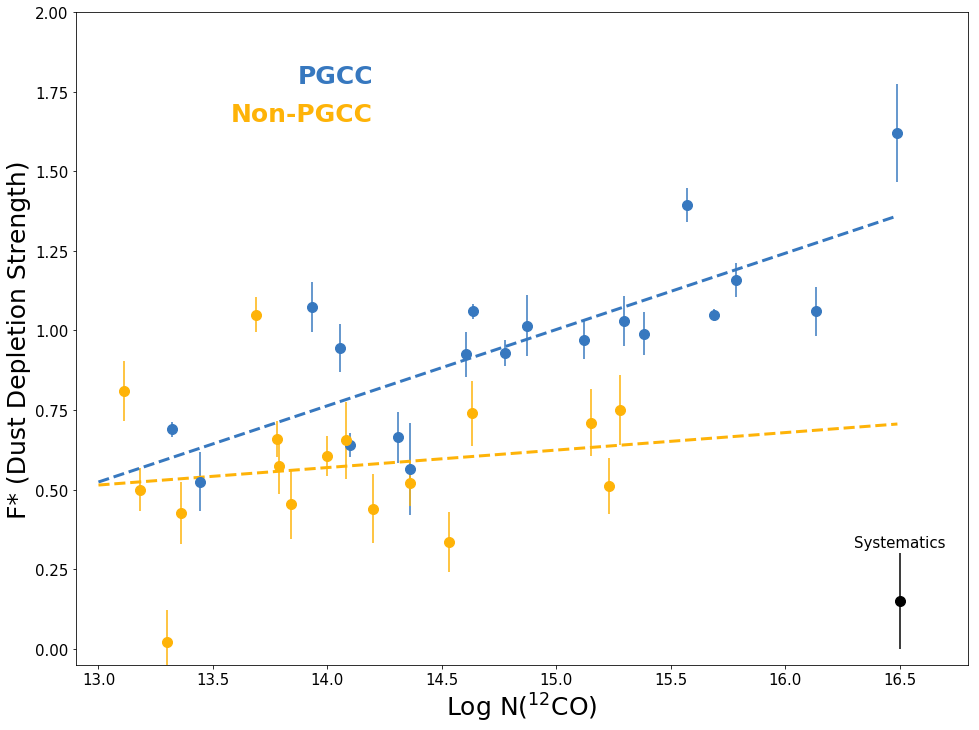

In [5]:
# Plots all calculated F* values against a given x parameter
x='CO'

els=['Ge','Kr','O','Ni','Mg']
els=['Ni','O','Ge']
cols=['r','g','b','k','y']
el1='Ni'

cut_data=all_data[(all_data['CO']>13)&(all_data['CO']<18)&(all_data['R_dist']<20)]

blue=xkcd_palette(['windows blue'])[0]
amber=xkcd_palette(['amber'])[0]

fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
subplt.set_ylim(-0.2,2)
#subplt.set_xlim(0,0.0001)

# Plots F* vs. CO in blue for strongest CO component in each of my sightlines
fit1x=np.empty(0)
fit1y=np.empty(0)
for sl in cut_data.groupby('Sightline'):
    # Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=get_f_star(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
            #subplt.plot(row[x],f,marker='o',color=cols[els.index(el2)])
    f_err=np.sqrt(np.sum(f_errs**2))
    subplt.errorbar(row[x],np.mean(f_vals),yerr=f_err,marker='o',color=blue,markersize=10)
    #subplt.text(row[x],np.mean(f_vals),row['Sightline'])
    fit1x=np.concatenate([fit1x,[row[x]]])
    fit1y=np.concatenate([fit1y,[np.mean(f_vals)]])
    #subplt.text(row[x],1.95,row['Sightline'],rotation=90,horizontalalignment='center',verticalalignment='top')
    
    
# Plots F* vs. CO in red for other sightlines (i.e. those not in my sample) from Jenkins x Sheffer sample
fit2x=np.empty(0)
fit2y=np.empty(0)
for idx,row in sightline_data[sightline_data['CO']>0].iterrows():
    co=row['CO']
    el1row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el1)]
    el1param=element_params[element_params['El']==el1].iloc[0]
    if len(el1row)>0:
        el1row=el1row.iloc[0]
        el1n=el1row['logNx']
        el1err=(el1row['B_logNx']-el1row['b_logNx'])/2.
        f_vals=np.empty(0)
        f_errs=np.empty(0)
        for el2 in [y for y in els if y != el1]:
            el2row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el2)]
            el2param=element_params[element_params['El']==el2].iloc[0]
            if len(el2row)>0:
                el2row=el2row.iloc[0]
                el2n=el2row['logNx']
                el2err=(el2row['B_logNx']-el2row['b_logNx'])/2.
                f,f_err=get_f_star(el1param,el2param,el1n,el2n,el1err,el2err)
                f_vals=np.concatenate([f_vals,[f]])
                f_errs=np.concatenate([f_errs,[f_err]])
                #subplt.plot(co,f,marker='x',color=cols[els.index(el2)])
        f_err=np.sqrt(np.sum(f_errs**2))
        subplt.errorbar(co,np.mean(f_vals),yerr=f_err,marker='o',color=amber,markersize=10)
        #subplt.text(co,np.mean(f_vals),row['Sightline'])
        fit2x=np.concatenate([fit2x,[co]])
        fit2y=np.concatenate([fit2y,[np.mean(f_vals)]])
        
fit1=linregress(x=fit1x,y=fit1y)
fit2=linregress(x=fit2x,y=fit2y) 

x=np.arange(13,16.5,0.01)
y1=fit1.slope*x+fit1.intercept
y2=fit2.slope*x+fit2.intercept
subplt.plot(x,y1,color=blue,linestyle='--',lw=3)
subplt.plot(x,y2,color=amber,linestyle='--',lw=3)

# Systematics Legend
subplt.errorbar(16.5,0.15,yerr=0.15,marker='o',color='k',markersize=10)
subplt.text(16.5,0.32,'Systematics',horizontalalignment='center',fontsize=15)

#subplt.plot(13,1.8,marker='o',color=blue,markersize=20)
subplt.text(14.2,1.8,'PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=blue)
#subplt.plot(13,1.7,marker='o',color=amber,markersize=20)
subplt.text(14.2,1.68,'Non-PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=amber)

subplt.set_xlim(12.9,16.8)
subplt.set_ylim(-0.05)
subplt.tick_params(axis='both', which='major', labelsize=15)
subplt.set_ylabel('F* (Dust Depletion Strength)',fontsize=25)
subplt.set_xlabel('Log N($^{12}$CO)',fontsize=25)
#plt.savefig('/Users/codydirks/Desktop/dustco.pdf')

In [ ]:
# Plots all calculated F* values against a given x parameter
x='CO'

els=['Ge','Kr','O','Ni','Mg']
els=['Ni','O','Ge']
el1='Ni'

cut_data=all_data[(all_data['CO']>13)&(all_data['CO']<18)&(all_data['R_dist']<20)]

fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)

# Plots F* vs. CO in blue for strongest CO component in each of my sightlines
fit1x=np.empty(0)
fit1y=np.empty(0)
for sl in cut_data.groupby('Sightline'):
    # Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=get_f_star(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
    f_err=np.sqrt(np.sum(f_errs**2))
    subplt.errorbar(row[x],np.mean(f_vals),yerr=f_err,marker='o',color=blue,markersize=10)
    fit1x=np.concatenate([fit1x,[row[x]]])
    fit1y=np.concatenate([fit1y,[np.mean(f_vals)]])
    
# Plots F* vs. CO in black for integrated column densities along each of my sightlines

fit3x=np.empty(0)
fit3y=np.empty(0)
for sl in cut_data.groupby('Sightline'):
    # Get strongest CO component for each sightline
    rows=all_data[all_data['Sightline']==sl[0]]
    co_sum=np.log10(np.sum(np.array(10**rows['CO'].values)))
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    el1_sum=np.log10(np.sum(np.array(10**rows[el1].values)))
    el1_err=np.log10(np.sum(np.array(10**rows[el1+'_err'].values)))
    for el2 in [y for y in els if y != el1]:
        if np.sum(rows[el2].values)>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            el2_sum=np.log10(np.sum(np.array(10**rows[el2].values)))
            el2_err=np.log10(np.sum(np.array(10**rows[el2+'_err'].values)))
            f,f_err=get_f_star(el1param,el2param,el1_sum,el2_sum,el1_err,el2_err)
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
    f_err=np.sqrt(np.sum(f_errs**2))
    subplt.errorbar(co_sum,np.mean(f_vals),yerr=0.05,marker='o',color='k',markersize=10)
    fit3x=np.concatenate([fit3x,[co_sum]])
    fit3y=np.concatenate([fit3y,[np.mean(f_vals)]])
    
# Plots F* vs. CO in yellow for other sightlines (i.e. those not in my sample) from Jenkins x Sheffer sample
fit2x=np.empty(0)
fit2y=np.empty(0)
for idx,row in sightline_data[sightline_data['CO']>0].iterrows():
    co=row['CO']
    el1row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el1)]
    el1param=element_params[element_params['El']==el1].iloc[0]
    if len(el1row)>0:
        el1row=el1row.iloc[0]
        el1n=el1row['logNx']
        el1err=(el1row['B_logNx']-el1row['b_logNx'])/2.
        f_vals=np.empty(0)
        f_errs=np.empty(0)
        for el2 in [y for y in els if y != el1]:
            el2row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el2)]
            el2param=element_params[element_params['El']==el2].iloc[0]
            if len(el2row)>0:
                el2row=el2row.iloc[0]
                el2n=el2row['logNx']
                el2err=(el2row['B_logNx']-el2row['b_logNx'])/2.
                f,f_err=get_f_star(el1param,el2param,el1n,el2n,el1err,el2err)
                f_vals=np.concatenate([f_vals,[f]])
                f_errs=np.concatenate([f_errs,[f_err]])
                #subplt.plot(co,f,marker='x',color=cols[els.index(el2)])
        f_err=np.sqrt(np.sum(f_errs**2))
        subplt.errorbar(co,np.mean(f_vals),yerr=f_err,marker='o',color=amber,markersize=10)
        #subplt.text(co,np.mean(f_vals),row['Sightline'])
        fit2x=np.concatenate([fit2x,[co]])
        fit2y=np.concatenate([fit2y,[np.mean(f_vals)]])
        
fit1=linregress(x=fit1x,y=fit1y)
fit2=linregress(x=fit2x,y=fit2y) 
fit3=linregress(x=fit3x,y=fit3y) 

x=np.arange(13,16.5,0.01)
y1=fit1.slope*x+fit1.intercept
y2=fit2.slope*x+fit2.intercept
y3=fit3.slope*x+fit3.intercept
subplt.plot(x,y1,color=blue,linestyle='--',lw=3)
subplt.plot(x,y2,color=amber,linestyle='--',lw=3)
subplt.plot(x,y3,color='k',linestyle='--',lw=3)

In [ ]:
# Recreates Jenkins plots for given elements
els=['Nickel','Germanium','Krypton']
cols=[blue,amber,'k']
fig=plt.figure(1,figsize=(16,16))
subplt=plt.subplot(111)
subplt.axvline(0,0,0.98,color='k',linestyle='-')
subplt.axhline(0,0.05,1,color='k',linestyle='-')
tx=np.arange(-0.1,1.5,0.1)

for element in els:
    el=element[0:2]
    eldata=element_params.loc[element_params['El']==el].iloc[0]
    ty=eldata['Bx']+eldata['Ax']*(tx-eldata['zx'])
    subplt.plot(tx,ty,'k--')
    for idx,row in element_data.loc[(element_data['El']==el)].iterrows():
        sldata=sightline_data.loc[sightline_data['Name']==row['Name']].iloc[0]
        depl=row['logNx']-sldata['N(H)']-(eldata['[X/H]']-12)
        subplt.plot(row['F*'],depl,marker='o',color=cols[els.index(element)],ms=9)
    subplt.text(tx[-1],ty[-1]+0.03,element,horizontalalignment='right',verticalalignment='bottom',
                fontsize=20,rotation=0.58*(180./np.pi)*np.arctan(eldata['Ax']))
    
ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)
subplt.set_xlabel('F* (Dust Depletion Strength)',fontsize=25,labelpad=20)
subplt.set_ylabel('Observed Depletion (dex)',fontsize=25,labelpad=20)
plt.savefig('/Users/codydirks/Desktop/jenkins_examples.pdf')

In [ ]:
els=['Ni','O']
el1='Ni'

fig=plt.figure(1,figsize=(16,8))
subplt=plt.subplot(111)
#subplt.set_xlim(13,16)

cut_data=all_data[(all_data['E(B-V)']>-9.99) & (all_data['CO']>13)]

for sl in cut_data.groupby('Sightline'):
    # Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]            
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=get_f_star(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
    f_err=np.sqrt(np.sum(f_errs**2))
    fuv_ext=(row['E(15-33)'])/row['E(B-V)']
    subplt.plot(np.mean(f_vals),fuv_ext,marker='o',color=blue,markersize=25)
    #subplt.text(np.mean(f_vals),fuv_ext,row['Sightline'])
    
for idx,row in sightline_data[(sightline_data['E(15-33)']>-9.99)&(sightline_data['CO']>13)].iterrows():
    el1row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el1)]
    el1param=element_params[element_params['El']==el1].iloc[0]
    o_row=element_data[(element_data['HD']==row['HD']) & (element_data['El']=='O')]
    if len(el1row)>0 and len(o_row)>0:
        el1row=el1row.iloc[0]
        el1n=el1row['logNx']
        el1err=(el1row['B_logNx']-el1row['b_logNx'])/2.
        f_vals=np.empty(0)
        f_errs=np.empty(0)
        for el2 in [y for y in els if y != el1]:
            el2row=element_data[(element_data['HD']==row['HD']) & (element_data['El']==el2)]
            el2param=element_params[element_params['El']==el2].iloc[0]
            if len(el2row)>0:
                el2row=el2row.iloc[0]
                el2n=el2row['logNx']
                el2err=(el2row['B_logNx']-el2row['b_logNx'])/2.
                f,f_err=get_f_star(el1param,el2param,el1n,el2n,el1err,el2err)
                f_vals=np.concatenate([f_vals,[f]])
                f_errs=np.concatenate([f_errs,[f_err]])
                #subplt.plot(co,f,marker='x',color=cols[els.index(el2)])
        f_err=np.sqrt(np.sum(f_errs**2))
        fuv_ext=(row['E(15-33)'])/row['E(B-V)']
        subplt.plot(np.mean(f_vals),fuv_ext,marker='o',color=amber,markersize=25)
        #subplt.text(np.mean(f_vals),fuv_ext,row['HD'])
        
        
        
subplt.text(1.3,4.7,'PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=blue)
subplt.text(1.3,4.47,'Non-PGCC',fontsize=25,weight='bold',verticalalignment='center',horizontalalignment='right',color=amber)
subplt.tick_params(axis='both', which='major', labelsize=15)
subplt.set_xlabel('F* (Dust Depletion Strength)',fontsize=25,labelpad=15)
subplt.set_ylabel('E(1500A-3300A)/E(B-V) (FUV Extinction)',fontsize=25,labelpad=15)
        
#plt.savefig('/Users/codydirks/Desktop/fuvext_vs_f.pdf')

(-0.1, 10.2)

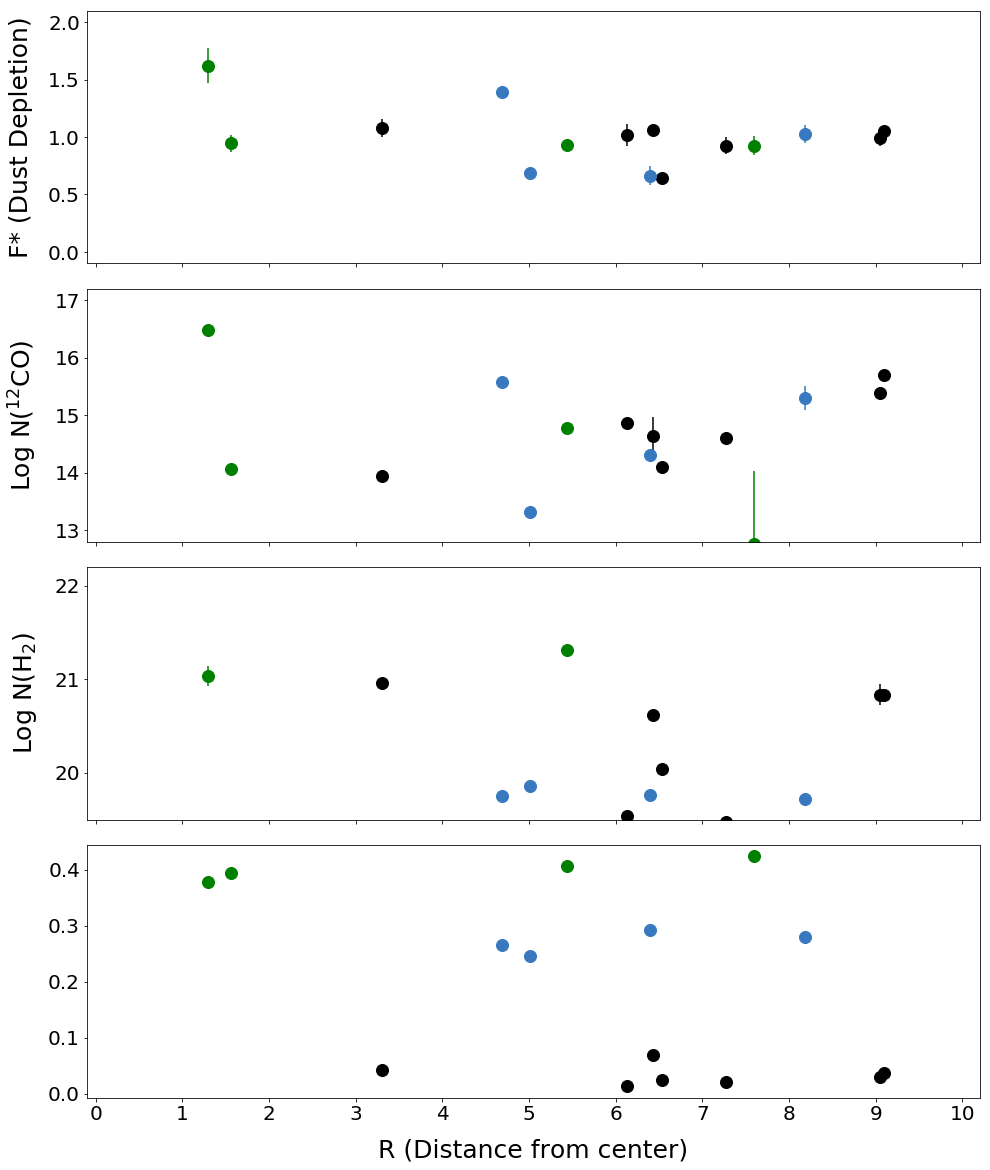

In [14]:
els=['O','Ni','Mg','Ge','Kr']
els=['O','Ni','Ge']#,'Mg','Ge','Kr']
el1='Ni'

fig,(subplt1,subplt2,subplt3,subplt4) = plt.subplots(4, sharex=True,figsize=(16,20))
fig.subplots_adjust(hspace=0.1)

cut_data=all_data[(all_data['CO']>=0)&(all_data['C']>0)&(all_data['Cl']>=0)&(all_data['R_dist']<20)]

fit1x=np.empty(0)
fit1y=np.empty(0)
for sl in cut_data.groupby('Sightline'):
    # Get strongest CO component for each sightline
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    f_vals=np.empty(0)
    f_errs=np.empty(0)
    el1param=element_params[element_params['El']==el1].iloc[0]
    for el2 in [y for y in els if y != el1]:
        if row[el2]>0:
            el2param=element_params[element_params['El']==el2].iloc[0]
            f,f_err=get_f_star(el1param,el2param,row[el1],row[el2],row[el1+'_err'],row[el2+'_err'])
            f_vals=np.concatenate([f_vals,[f]])
            f_errs=np.concatenate([f_errs,[f_err]])
            #subplt.plot(row[x],f,marker='o',color=cols[els.index(el2)])
    f_err=np.sqrt(np.sum(f_errs**2))
    f1=10**row['C*']/np.sum([10**row[col] for col in ('C','C*','C**')])
    if f1<0.1:
        col='k'
    elif 0.1<f1<0.21:
        col='w'
    elif 0.21<f1<0.35:
        col=blue
    elif f1>0.35:
        col='g'
    
    subplt1.errorbar(row['R_dist'],np.mean(f_vals),yerr=f_err,marker='o',color=col,markersize=12)
    
    subplt2.errorbar(row['R_dist'],row['CO'],yerr=row['CO_err']/0.434,color=col,marker='o',markersize=12)
    
    subplt3.errorbar(row['R_dist'],row['H_2'],yerr=row['Cl_err']/row['Cl']*row['H_2'],color=col,marker='o',markersize=12)
    
    #subplt4.errorbar(row['R_dist'],np.log10(row['f_H2']),yerr=np.sqrt((row['Cl_err']/0.434)**2+(row['O_err']/0.434)**2),color=col,marker='o',markersize=12)
    subplt4.plot(row['R_dist'],f1,color=col,marker='o',markersize=12)
    
subplt1.set_ylim(-0.1,2.1)
subplt1.set_ylabel('F* (Dust Depletion)',fontsize=25,labelpad=15)
majorLocator = MultipleLocator(0.5)
subplt1.yaxis.set_major_locator(majorLocator)
subplt1.tick_params(axis='y', which='major', labelsize=20)

subplt2.set_ylim(12.8,17.2)
subplt2.set_ylabel('Log N($^{12}$CO)',fontsize=25,labelpad=15)
majorLocator = MultipleLocator(1.0)
subplt2.yaxis.set_major_locator(majorLocator)
subplt2.tick_params(axis='y', which='major', labelsize=20)

subplt3.set_ylim(19.5,22.2)
subplt3.set_ylabel('Log N(H$_{2}$)',fontsize=25,labelpad=15)
majorLocator = MultipleLocator(1.0)
subplt3.yaxis.set_major_locator(majorLocator)
subplt3.tick_params(axis='y', which='major', labelsize=20)

#subplt4.set_ylim(-1.4,1.3)
#subplt4.set_ylabel('Log f$_{H_{2}}$',fontsize=25,labelpad=15)
subplt4.tick_params(axis='y', which='major', labelsize=20)

majorLocator = MultipleLocator(1.0)
subplt4.xaxis.set_major_locator(majorLocator)
subplt4.tick_params(axis='x',which='major',labelsize=20)
subplt4.set_xlabel('R (Distance from center)',fontsize=25,labelpad=15)
subplt4.set_xlim(-0.1,10.2)

#plt.savefig('/Users/codydirks/Desktop/plots/rdist_plots.pdf')

In [ ]:
cos1=[]
co_errs1=[]
cut_data=all_data[(all_data['CO']>13)&(all_data['R_dist']<20)&(all_data['Cl']>13.5)]
for sl in cut_data.groupby('Sightline'):
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    cos1.append(10**(row['CO']-row['H_2']))
    co_errs1.append(10**(row['CO']-row['H_2'])*np.sqrt((row['CO_err']/0.434)**2+(row['Cl_err'])**2))
    
cos1=np.array(cos1)
co_errs=np.array(co_errs1)
print np.mean(cos1)


In [ ]:
cos2=[]
co_errs2=[]
for idx,row in sightline_data.iterrows():
    if row['CO']>0:
        cos2.append(10**(row['CO']-row['logNH2']))
        co_err=0.05
        h2_err=(float(row['ul_logNH2'])-float(row['ll_logNH2']))/2.
        co_errs2.append(10**(row['CO']-row['logNH2'])*np.sqrt((co_err/0.434)**2+(h2_err)**2))
        
cos2=np.array(cos2)
print np.mean(cos2)

In [ ]:
print np.mean(cos1),np.mean(cos1)*np.sqrt(np.sum((co_errs1/cos1)**2))
print np.mean(cos2),np.mean(cos2)*np.sqrt(np.sum((co_errs2/cos2)**2))

In [ ]:
for sl in cut_data.groupby('Sightline'):
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    print row['CO_err']

In [ ]:
cut_data=all_data[(all_data['CO']>13)&(all_data['CO']<18)&(all_data['R_dist']<20)]
for sl in cut_data.groupby('Sightline'):
    print len(sl[1]),len(all_data[all_data['Sightline']==sl[0]])